# Overview


**Goal: Run scgen on system**

* This code closely follows what is here: https://colab.research.google.com/github/theislab/scgen/blob/master/docs/tutorials/scgen_perturbation_prediction.ipynb#scrollTo=OErSTnlUkT7S


* Follow instructions here to set up scgen on your system: https://scgen.readthedocs.io/en/latest/installation.html



In [ ]:
!pip install scanpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.2/104.2 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.8/90.8 kB 10.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 51.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 7.7 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.4-py3-none-any.whl size=86770 sha256=e5ff9e43a0b6e6f94051f564de67930b1d8083b33b2f2a271b74eb569d175ba4
  Stored in directory: /root/.cache/pip/wheels/fb/66/29/199acf5784d0f7b8add6d466175ab45506c96e386ed5dd0633
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8026 sha256=c0dda7bfec8a8c06c83f26806325f79730732b4b1db35248a081d4794b4fa538
  Stored in directory: /root/.cache/pip/wheels/6a/a

In [ ]:
!pip install git+https://github.com/theislab/scgen.git

In [ ]:

import numpy as np
import scanpy as sc
import scgen

/usr/local/lib/python3.10/dist-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/usr/local/lib/python3.10/dist-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (


In [ ]:
train = sc.read("./tests/data/train_kang.h5ad",
                backup_url='https://drive.google.com/uc?id=1r87vhoLLq6PXAYdmyyd89zG90eJOFYLk')

  0%|          | 0.00/22.4M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/anndata/compat/__init__.py:229: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
/usr/local/lib/python3.10/dist-packages/anndata/compat/__init__.py:229: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(


In [ ]:
train_new = train[~((train.obs["cell_type"] == "CD4T") &
                    (train.obs["condition"] == "stimulated"))]

In [ ]:
## made a copy of train_new because code produced error when
## train_new was input into setup_anndata directly

## old code which produced error
#scgen.SCGEN.setup_anndata(train_new, batch_key="condition", labels_key="cell_type")

train_new2 = train_new.copy()
scgen.SCGEN.setup_anndata(train_new2, batch_key="condition", labels_key="cell_type")

In [ ]:
model = scgen.SCGEN(train_new2)
model.save("saved_models/model_perturbation_prediction.pt", overwrite=True)

In [ ]:
## changed max_epochs to 3 to make things run fast
model.train(
    max_epochs=3,
    batch_size=32,
    early_stopping=True,
    early_stopping_patience=25
)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Epoch 3/3: 100%|██████████| 3/3 [03:24<00:00, 66.63s/it, v_num=1, train_loss_step=85, train_loss_epoch=83.8]  

INFO: `Trainer.fit` stopped: `max_epochs=3` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|██████████| 3/3 [03:24<00:00, 68.08s/it, v_num=1, train_loss_step=85, train_loss_epoch=83.8]


In [ ]:
latent_X = model.get_latent_representation()
latent_adata = sc.AnnData(X=latent_X, obs=train_new.obs.copy())

         Falling back to preprocessing with `sc.pp.pca` and default params.


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


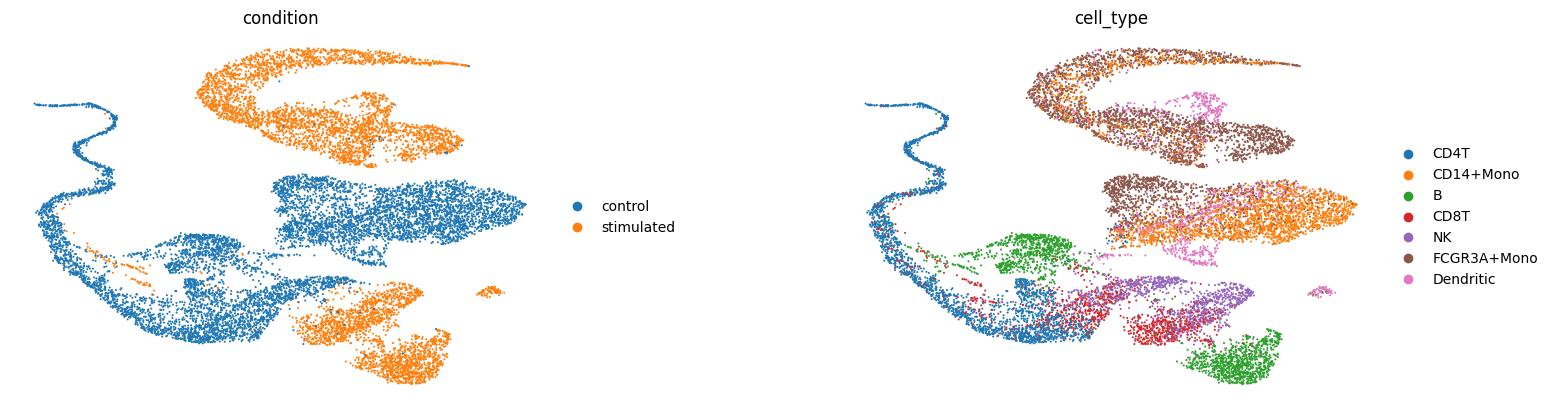

In [ ]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)
sc.pl.umap(latent_adata, color=['condition', 'cell_type'], wspace=0.4, frameon=False,
           save='latentspace_batch32_klw000005_z100__100e.pdf')

In [ ]:
pred, delta = model.predict(
    ctrl_key='control',
    stim_key='stimulated',
    celltype_to_predict='CD4T'
)
pred.obs['condition'] = 'pred'

INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


In [ ]:
import pandas as pd
pred_df = pd.DataFrame(pred.X)
pred_df.to_csv("pred_CD4T.csv")

In [ ]:
ctrl_adata = train[((train.obs['cell_type'] == 'CD4T') & (train.obs['condition'] == 'control'))]
stim_adata = train[((train.obs['cell_type'] == 'CD4T') & (train.obs['condition'] == 'stimulated'))]

In [ ]:
eval_adata = ctrl_adata.concatenate(stim_adata, pred)

/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


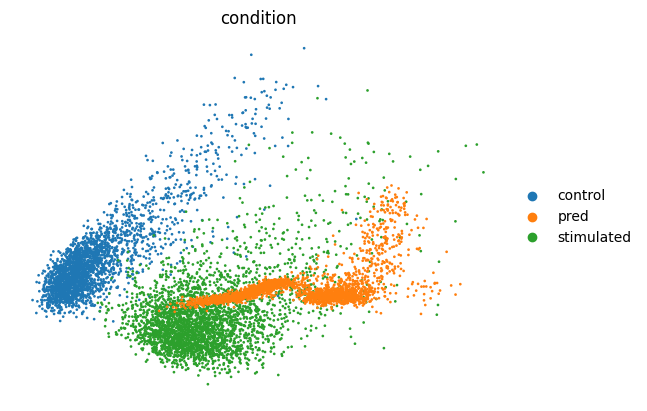

In [ ]:
sc.tl.pca(eval_adata)
sc.pl.pca(eval_adata, color="condition", frameon=False,
           save='pred_stim_b32_klw000005_z100__100e.pdf')

In [ ]:
CD4T = train[train.obs["cell_type"] =="CD4T"]

In [ ]:
sc.tl.rank_genes_groups(CD4T, groupby="condition", method="wilcoxon")
diff_genes = CD4T.uns["rank_genes_groups"]["names"]["stimulated"]
print(diff_genes)
print(len(diff_genes))

/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:582: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


['ISG15' 'IFI6' 'ISG20' ... 'FTL' 'RGCC' 'FTH1']
6998


"['ISG15' 'IFI6' 'ISG20' ... 'FTL' 'RGCC' 'FTH1']"

In [ ]:
r2_value = model.reg_mean_plot(
    eval_adata,
    axis_keys={"x": "pred", "y": "stimulated"},
    gene_list=diff_genes[:10],
    labels={"x": "predicted", "y": "ground truth"},
    path_to_save="./reg_mean1.pdf",
    show=True,
    legend=False
)

In [ ]:
r2_value = model.reg_mean_plot(
    eval_adata,
    axis_keys={"x": "pred", "y": "stimulated"},
    gene_list=diff_genes[:10],
    top_100_genes= diff_genes,
    labels={"x": "predicted","y": "ground truth"},
    path_to_save="./reg_mean1.pdf",
    show=True,
    legend=False
)

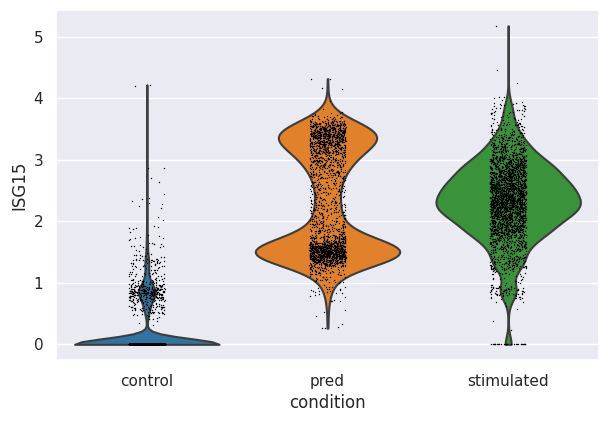

In [ ]:
sc.pl.violin(eval_adata, keys="ISG15", groupby="condition")

In [ ]:
# training for a new cell type
train_new = train[~((train.obs["cell_type"] == "CD14+Mono") &
                    (train.obs["condition"] == "stimulated"))]

train_new2 = train_new.copy()
scgen.SCGEN.setup_anndata(train_new2, batch_key="condition", labels_key="cell_type")
model = scgen.SCGEN(train_new2)
model.save("saved_models/model_perturbation_prediction.pt", overwrite=True)

In [ ]:
model.train(
    max_epochs=3,
    batch_size=32,
    early_stopping=True,
    early_stopping_patience=25
)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Epoch 3/3: 100%|██████████| 3/3 [03:39<00:00, 72.84s/it, v_num=1, train_loss_step=85.2, train_loss_epoch=87.5]

INFO: `Trainer.fit` stopped: `max_epochs=3` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|██████████| 3/3 [03:39<00:00, 73.11s/it, v_num=1, train_loss_step=85.2, train_loss_epoch=87.5]


In [ ]:
# predict at a new cell type
pred, delta = model.predict(
    ctrl_key='control',
    stim_key='stimulated',
    celltype_to_predict='CD14+Mono'
)
pred.obs['condition'] = 'pred'
ctrl_adata = train[((train.obs['cell_type'] == 'CD14+Mono') & (train.obs['condition'] == 'control'))]
stim_adata = train[((train.obs['cell_type'] == 'CD14+Mono') & (train.obs['condition'] == 'stimulated'))]
eval_adata = ctrl_adata.concatenate(stim_adata, pred)
sc.tl.pca(eval_adata)
sc.pl.pca(eval_adata, color="condition", frameon=False,
           save='pred_stim_b32_klw000005_z100__100e_test.pdf')

In [ ]:
pred.X.shape
pred_df = pd.DataFrame(pred.X)
pred_df.to_csv("pred_CD14.csv")

In [ ]:
CD14 = train[train.obs["cell_type"] =="CD14+Mono"]
sc.tl.rank_genes_groups(CD14, groupby="condition", method="wilcoxon")
diff_genes = CD14.uns["rank_genes_groups"]["names"]["stimulated"]
print(diff_genes)
print(len(diff_genes))

/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:582: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


['ISG15' 'ISG20' 'IFITM3' ... 'ACTB' 'PFN1' 'IL8']
6998


In [ ]:
r2_value = model.reg_mean_plot(
    eval_adata,
    axis_keys={"x": "pred", "y": "stimulated"},
    gene_list=diff_genes[:10],
    labels={"x": "predicted", "y": "ground truth"},
    path_to_save="./reg_mean2.pdf",
    show=True,
    legend=False
)

In [ ]:
sc.pl.violin(eval_adata, keys="ISG15", groupby="condition")

In [ ]:
## cell type B
train_new = train[~((train.obs["cell_type"] == "B") &
                    (train.obs["condition"] == "stimulated"))]

train_new2 = train_new.copy()
scgen.SCGEN.setup_anndata(train_new2, batch_key="condition", labels_key="cell_type")
model = scgen.SCGEN(train_new2)
model.save("saved_models/model_perturbation_prediction.pt", overwrite=True)
model.train(
    max_epochs=3,
    batch_size=32,
    early_stopping=True,
    early_stopping_patience=25
)
pred, delta = model.predict(
    ctrl_key='control',
    stim_key='stimulated',
    celltype_to_predict='B'
)
pred.obs['condition'] = 'pred'
ctrl_adata = train[((train.obs['cell_type'] == 'B') & (train.obs['condition'] == 'control'))]
stim_adata = train[((train.obs['cell_type'] == 'B') & (train.obs['condition'] == 'stimulated'))]
eval_adata = ctrl_adata.concatenate(stim_adata, pred)
sc.tl.pca(eval_adata)
sc.pl.pca(eval_adata, color="condition", frameon=False,
           save='pred_stim_b32_klw000005_z100__100e_test.pdf')
pred.X.shape
pred_df = pd.DataFrame(pred.X)
pred_df.to_csv("pred_B.csv")

In [ ]:
pred.X.shape
pred_df = pd.DataFrame(pred.X)
pred_df.to_csv("pred_B.csv")

In [ ]:
pred.X.shape

(818, 6998)

In [ ]:
## cell type CD8T
train_new = train[~((train.obs["cell_type"] == "CD8T") &
                    (train.obs["condition"] == "stimulated"))]

train_new2 = train_new.copy()
scgen.SCGEN.setup_anndata(train_new2, batch_key="condition", labels_key="cell_type")
model = scgen.SCGEN(train_new2)
model.save("saved_models/model_perturbation_prediction.pt", overwrite=True)
model.train(
    max_epochs=3,
    batch_size=32,
    early_stopping=True,
    early_stopping_patience=25
)
pred, delta = model.predict(
    ctrl_key='control',
    stim_key='stimulated',
    celltype_to_predict='CD8T'
)
pred.obs['condition'] = 'pred'
ctrl_adata = train[((train.obs['cell_type'] == 'CD8T') & (train.obs['condition'] == 'control'))]
stim_adata = train[((train.obs['cell_type'] == 'CD8T') & (train.obs['condition'] == 'stimulated'))]
eval_adata = ctrl_adata.concatenate(stim_adata, pred)
sc.tl.pca(eval_adata)
sc.pl.pca(eval_adata, color="condition", frameon=False,
           save='pred_stim_b32_klw000005_z100__100e_test.pdf')

In [ ]:
pred_df = pd.DataFrame(pred.X)
pred_df.to_csv("pred_CD8T.csv")

In [ ]:
pred_df.shape

(574, 6998)

In [ ]:
## cell type Dendritic
train_new = train[~((train.obs["cell_type"] == "Dendritic") &
                    (train.obs["condition"] == "stimulated"))]

train_new2 = train_new.copy()
scgen.SCGEN.setup_anndata(train_new2, batch_key="condition", labels_key="cell_type")
model = scgen.SCGEN(train_new2)
model.save("saved_models/model_perturbation_prediction.pt", overwrite=True)
model.train(
    max_epochs=3,
    batch_size=32,
    early_stopping=True,
    early_stopping_patience=25
)
pred, delta = model.predict(
    ctrl_key='control',
    stim_key='stimulated',
    celltype_to_predict='Dendritic'
)
pred.obs['condition'] = 'pred'
ctrl_adata = train[((train.obs['cell_type'] == 'Dendritic') & (train.obs['condition'] == 'control'))]
stim_adata = train[((train.obs['cell_type'] == 'Dendritic') & (train.obs['condition'] == 'stimulated'))]
eval_adata = ctrl_adata.concatenate(stim_adata, pred)
sc.tl.pca(eval_adata)
sc.pl.pca(eval_adata, color="condition", frameon=False,
           save='pred_stim_b32_klw000005_z100__100e_test.pdf')

In [ ]:
pred_df = pd.DataFrame(pred.X)
pred_df.to_csv("pred_Dendritic.csv")

In [ ]:
pred_df.shape

(615, 6998)

In [ ]:
## cell type FCGR3A+Mono
train_new = train[~((train.obs["cell_type"] == "FCGR3A+Mono") &
                    (train.obs["condition"] == "stimulated"))]

train_new2 = train_new.copy()
scgen.SCGEN.setup_anndata(train_new2, batch_key="condition", labels_key="cell_type")
model = scgen.SCGEN(train_new2)
model.save("saved_models/model_perturbation_prediction.pt", overwrite=True)
model.train(
    max_epochs=3,
    batch_size=32,
    early_stopping=True,
    early_stopping_patience=25
)
pred, delta = model.predict(
    ctrl_key='control',
    stim_key='stimulated',
    celltype_to_predict='FCGR3A+Mono'
)
pred.obs['condition'] = 'pred'
ctrl_adata = train[((train.obs['cell_type'] == 'FCGR3A+Mono') & (train.obs['condition'] == 'control'))]
stim_adata = train[((train.obs['cell_type'] == 'FCGR3A+Mono') & (train.obs['condition'] == 'stimulated'))]
eval_adata = ctrl_adata.concatenate(stim_adata, pred)
sc.tl.pca(eval_adata)
sc.pl.pca(eval_adata, color="condition", frameon=False,
           save='pred_stim_b32_klw000005_z100__100e_test.pdf')

In [ ]:
pred_df = pd.DataFrame(pred.X)
pred_df.to_csv("pred_FCGR3A.csv")

In [ ]:
pred_df.shape

(1100, 6998)

In [ ]:
## cell type NK
train_new = train[~((train.obs["cell_type"] == "NK") &
                    (train.obs["condition"] == "stimulated"))]

train_new2 = train_new.copy()
scgen.SCGEN.setup_anndata(train_new2, batch_key="condition", labels_key="cell_type")
model = scgen.SCGEN(train_new2)
model.save("saved_models/model_perturbation_prediction.pt", overwrite=True)
model.train(
    max_epochs=3,
    batch_size=32,
    early_stopping=True,
    early_stopping_patience=25
)
pred, delta = model.predict(
    ctrl_key='control',
    stim_key='stimulated',
    celltype_to_predict='NK'
)
pred.obs['condition'] = 'pred'
ctrl_adata = train[((train.obs['cell_type'] == 'NK') & (train.obs['condition'] == 'control'))]
stim_adata = train[((train.obs['cell_type'] == 'NK') & (train.obs['condition'] == 'stimulated'))]
eval_adata = ctrl_adata.concatenate(stim_adata, pred)
sc.tl.pca(eval_adata)
sc.pl.pca(eval_adata, color="condition", frameon=False,
           save='pred_stim_b32_klw000005_z100__100e_test.pdf')

In [ ]:
pred_df = pd.DataFrame(pred.X)
pred_df.to_csv("pred_NK.csv")

In [ ]:
pred_df.shape

In [ ]:
### DE genes CD4T
CD4T = train[train.obs["cell_type"] =="CD4T"]
sc.tl.rank_genes_groups(CD4T, groupby="condition", method="wilcoxon")
diff_genes = CD4T.uns["rank_genes_groups"]["names"]["stimulated"]
logfc = CD4T.uns["rank_genes_groups"]["logfoldchanges"]["stimulated"]
adj_pvals = CD4T.uns["rank_genes_groups"]["pvals_adj"]["stimulated"]
diff_genes = pd.DataFrame(diff_genes).T
adj_pvals = pd.DataFrame(adj_pvals).T
logfc = pd.DataFrame(logfc).T
CD4T_DE = diff_genes.append(adj_pvals)
CD4T_DE = CD4T_DE.append(logfc)
CD4T_DE.to_csv("DEgene_CD4T.csv")

/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:582: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
<ipython-input-157-a5fe9af208e4>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  CD4T_DE = diff_genes.append(adj_pvals)
<ipython-input-157-a5fe9af208e4>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  CD4T_DE = CD4T_DE.append(logfc)


In [ ]:
### DE genes B
B = train[train.obs["cell_type"] =="B"]
sc.tl.rank_genes_groups(B, groupby="condition", method="wilcoxon")
diff_genes = B.uns["rank_genes_groups"]["names"]["stimulated"]
logfc = B.uns["rank_genes_groups"]["logfoldchanges"]["stimulated"]
adj_pvals = B.uns["rank_genes_groups"]["pvals_adj"]["stimulated"]
diff_genes = pd.DataFrame(diff_genes).T
adj_pvals = pd.DataFrame(adj_pvals).T
logfc = pd.DataFrame(logfc).T
B_DE = diff_genes.append(adj_pvals)
B_DE = B_DE.append(logfc)
B_DE.to_csv("DEgene_B.csv")

/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:582: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
<ipython-input-158-34a564e1c5d5>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  B_DE = diff_genes.append(adj_pvals)
<ipython-input-158-34a564e1c5d5>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  B_DE = B_DE.append(logfc)


In [ ]:
### DE genes CD8T
CD8T = train[train.obs["cell_type"] =="CD8T"]
sc.tl.rank_genes_groups(CD8T, groupby="condition", method="wilcoxon")
diff_genes = CD8T.uns["rank_genes_groups"]["names"]["stimulated"]
logfc = CD8T.uns["rank_genes_groups"]["logfoldchanges"]["stimulated"]
adj_pvals = CD8T.uns["rank_genes_groups"]["pvals_adj"]["stimulated"]
diff_genes = pd.DataFrame(diff_genes).T
adj_pvals = pd.DataFrame(adj_pvals).T
logfc = pd.DataFrame(logfc).T
CD8T_DE = diff_genes.append(adj_pvals)
CD8T_DE = CD8T_DE.append(logfc)
CD8T_DE.to_csv("DEgene_CD8T.csv")

/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:582: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
<ipython-input-160-5132897bed97>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  CD8T_DE = diff_genes.append(adj_pvals)
<ipython-input-160-5132897bed97>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  CD8T_DE = CD8T_DE.append(logfc)


In [ ]:
### DE genes CD14
CD14 = train[train.obs["cell_type"] =="CD14+Mono"]
sc.tl.rank_genes_groups(CD14, groupby="condition", method="wilcoxon")
diff_genes = CD14.uns["rank_genes_groups"]["names"]["stimulated"]
logfc = CD14.uns["rank_genes_groups"]["logfoldchanges"]["stimulated"]
adj_pvals = CD14.uns["rank_genes_groups"]["pvals_adj"]["stimulated"]
diff_genes = pd.DataFrame(diff_genes).T
adj_pvals = pd.DataFrame(adj_pvals).T
logfc = pd.DataFrame(logfc).T
CD14_DE = diff_genes.append(adj_pvals)
CD14_DE = CD14_DE.append(logfc)
CD14_DE.to_csv("DEgene_CD14.csv")

/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:582: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
<ipython-input-161-8f6327ff6986>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  CD14_DE = diff_genes.append(adj_pvals)
<ipython-input-161-8f6327ff6986>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  CD14_DE = CD14_DE.append(logfc)


In [ ]:
### DE genes Dendritic
Dendritic = train[train.obs["cell_type"] =="Dendritic"]
sc.tl.rank_genes_groups(Dendritic, groupby="condition", method="wilcoxon")
diff_genes = Dendritic.uns["rank_genes_groups"]["names"]["stimulated"]
logfc = Dendritic.uns["rank_genes_groups"]["logfoldchanges"]["stimulated"]
adj_pvals = Dendritic.uns["rank_genes_groups"]["pvals_adj"]["stimulated"]
diff_genes = pd.DataFrame(diff_genes).T
adj_pvals = pd.DataFrame(adj_pvals).T
logfc = pd.DataFrame(logfc).T
Dendritic_DE = diff_genes.append(adj_pvals)
Dendritic_DE = Dendritic_DE.append(logfc)
Dendritic_DE.to_csv("DEgene_Dendritic.csv")

/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:582: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
<ipython-input-165-4fd865fc7b6d>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Dendritic_DE = diff_genes.append(adj_pvals)
<ipython-input-165-4fd865fc7b6d>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Dendritic_DE = Dendritic_DE.append(logfc)


In [ ]:
### DE genes FCGR3A
FCGR3A = train[train.obs["cell_type"] =="FCGR3A+Mono"]
sc.tl.rank_genes_groups(FCGR3A, groupby="condition", method="wilcoxon")
diff_genes = FCGR3A.uns["rank_genes_groups"]["names"]["stimulated"]
logfc = FCGR3A.uns["rank_genes_groups"]["logfoldchanges"]["stimulated"]
adj_pvals = FCGR3A.uns["rank_genes_groups"]["pvals_adj"]["stimulated"]
diff_genes = pd.DataFrame(diff_genes).T
adj_pvals = pd.DataFrame(adj_pvals).T
logfc = pd.DataFrame(logfc).T
FCGR3A_DE = diff_genes.append(adj_pvals)
FCGR3A_DE = FCGR3A_DE.append(logfc)
FCGR3A_DE.to_csv("DEgene_FCGR3A.csv")

/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:582: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
<ipython-input-166-51adc879ff0b>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  FCGR3A_DE = diff_genes.append(adj_pvals)
<ipython-input-166-51adc879ff0b>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  FCGR3A_DE = FCGR3A_DE.append(logfc)


In [ ]:
### DE genes NK
NK = train[train.obs["cell_type"] =="NK"]
sc.tl.rank_genes_groups(NK, groupby="condition", method="wilcoxon")
diff_genes = NK.uns["rank_genes_groups"]["names"]["stimulated"]
logfc = NK.uns["rank_genes_groups"]["logfoldchanges"]["stimulated"]
adj_pvals = NK.uns["rank_genes_groups"]["pvals_adj"]["stimulated"]
diff_genes = pd.DataFrame(diff_genes).T
adj_pvals = pd.DataFrame(adj_pvals).T
logfc = pd.DataFrame(logfc).T
NK_DE = diff_genes.append(adj_pvals)
NK_DE = NK_DE.append(logfc)
NK_DE.to_csv("DEgene_NK.csv")

/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:582: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
<ipython-input-167-7e9ec95386e7>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  NK_DE = diff_genes.append(adj_pvals)
<ipython-input-167-7e9ec95386e7>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  NK_DE = NK_DE.append(logfc)
